In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\gianm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_data():    
    data = pd.read_csv('dataset.csv')
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

In [4]:
def build_model(trial, input_dim):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 1, 5)

    # First Layer
    units = trial.suggest_int(f"n_units_i", 16, 256, step=16)
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = trial.suggest_float(f"dropout_rate", 0.0, 0.5)
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = trial.suggest_int(f"n_units_h", 16, 256, step=16) 
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_float("lr", 1e-4, 1e-2, log=True)),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model


In [5]:
def objective(trial):
    X, y = load_data()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = build_model(trial, input_dim=X_train.shape[1])
        model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracies.append(accuracy_score(y_test, y_pred))
    
    return np.mean(accuracies)

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters:", study.best_params)

[I 2025-01-12 11:06:49,594] A new study created in memory with name: no-name-0a36ba6b-2878-40d1-a704-f3108c7b89f5


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:07:23,979] Trial 0 finished with value: 0.8347324024440412 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.3475328770872465, 'n_units_h': 64, 'lr': 0.0001824341593239537}. Best is trial 0 with value: 0.8347324024440412.


306/306 [==============================] - 0s 512us/step


[I 2025-01-12 11:07:49,719] Trial 1 finished with value: 0.8348552001689479 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.10726012989499595, 'n_units_h': 80, 'lr': 0.0004255020679933103}. Best is trial 1 with value: 0.8348552001689479.


306/306 [==============================] - 0s 590us/step


[I 2025-01-12 11:08:49,222] Trial 2 finished with value: 0.8344253064797644 and parameters: {'n_layers': 5, 'n_units_i': 32, 'dropout_rate': 0.24676261930136822, 'n_units_h': 112, 'lr': 0.0028340948635196543}. Best is trial 1 with value: 0.8348552001689479.


306/306 [==============================] - 0s 561us/step


[I 2025-01-12 11:09:28,264] Trial 3 finished with value: 0.835407994283007 and parameters: {'n_layers': 5, 'n_units_i': 112, 'dropout_rate': 0.1338023698867452, 'n_units_h': 48, 'lr': 0.0003691616696359053}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 818us/step


[I 2025-01-12 11:10:30,441] Trial 4 finished with value: 0.8348142270729024 and parameters: {'n_layers': 4, 'n_units_i': 112, 'dropout_rate': 0.45861658573074815, 'n_units_h': 208, 'lr': 0.0008623035436797251}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 11:10:48,449] Trial 5 finished with value: 0.8340157809192512 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.15874265494998147, 'n_units_h': 16, 'lr': 0.009744754921011194}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 707us/step


[I 2025-01-12 11:11:48,020] Trial 6 finished with value: 0.8293681881101268 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.4891067297002029, 'n_units_h': 256, 'lr': 0.007279548337825555}. Best is trial 3 with value: 0.835407994283007.


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:12:12,128] Trial 7 finished with value: 0.8354694738382935 and parameters: {'n_layers': 1, 'n_units_i': 64, 'dropout_rate': 0.1896961902748603, 'n_units_h': 96, 'lr': 0.002924592545786669}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 623us/step


[I 2025-01-12 11:13:03,413] Trial 8 finished with value: 0.8346504604437863 and parameters: {'n_layers': 4, 'n_units_i': 224, 'dropout_rate': 0.3299773325125916, 'n_units_h': 96, 'lr': 0.000519853474887041}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 595us/step


[I 2025-01-12 11:13:46,434] Trial 9 finished with value: 0.8347323919644525 and parameters: {'n_layers': 4, 'n_units_i': 160, 'dropout_rate': 0.34652349894269024, 'n_units_h': 128, 'lr': 0.000455453138039812}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 623us/step


[I 2025-01-12 11:14:15,861] Trial 10 finished with value: 0.8348961502098977 and parameters: {'n_layers': 2, 'n_units_i': 16, 'dropout_rate': 0.020339910520368376, 'n_units_h': 176, 'lr': 0.0021090369379438948}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 571us/step


[I 2025-01-12 11:14:42,483] Trial 11 finished with value: 0.8317840581813352 and parameters: {'n_layers': 5, 'n_units_i': 64, 'dropout_rate': 0.16779065994686176, 'n_units_h': 16, 'lr': 0.003285623420812665}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 557us/step


[I 2025-01-12 11:15:07,819] Trial 12 finished with value: 0.832869230074676 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.04914199195596283, 'n_units_h': 48, 'lr': 0.000112158256535689}. Best is trial 7 with value: 0.8354694738382935.


306/306 [==============================] - 0s 557us/step


[I 2025-01-12 11:15:40,757] Trial 13 finished with value: 0.8361041282118158 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.2215863967530906, 'n_units_h': 160, 'lr': 0.0013720677874729718}. Best is trial 13 with value: 0.8361041282118158.


306/306 [==============================] - 0s 589us/step


[I 2025-01-12 11:16:13,012] Trial 14 finished with value: 0.8362269594714062 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.2435176042315698, 'n_units_h': 160, 'lr': 0.0016103564312612431}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 559us/step


[I 2025-01-12 11:16:49,040] Trial 15 finished with value: 0.8352237086191432 and parameters: {'n_layers': 2, 'n_units_i': 160, 'dropout_rate': 0.2547555807826318, 'n_units_h': 160, 'lr': 0.0013527414167508142}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 794us/step


[I 2025-01-12 11:17:25,790] Trial 16 finished with value: 0.8357765656107349 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.24884843014427643, 'n_units_h': 208, 'lr': 0.0011068684857845285}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 631us/step


[I 2025-01-12 11:18:12,436] Trial 17 finished with value: 0.8311288491424638 and parameters: {'n_layers': 3, 'n_units_i': 256, 'dropout_rate': 0.41240971769302726, 'n_units_h': 160, 'lr': 0.005021943021880043}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 628us/step


[I 2025-01-12 11:18:45,597] Trial 18 finished with value: 0.8339543390904842 and parameters: {'n_layers': 2, 'n_units_i': 32, 'dropout_rate': 0.2932972873790602, 'n_units_h': 208, 'lr': 0.0016188775276862566}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 590us/step


[I 2025-01-12 11:19:23,595] Trial 19 finished with value: 0.8354284860708241 and parameters: {'n_layers': 3, 'n_units_i': 80, 'dropout_rate': 0.2033442153374136, 'n_units_h': 144, 'lr': 0.0007584692863872204}. Best is trial 14 with value: 0.8362269594714062.


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:19:50,595] Trial 20 finished with value: 0.8362679199919449 and parameters: {'n_layers': 1, 'n_units_i': 96, 'dropout_rate': 0.09302479596209434, 'n_units_h': 240, 'lr': 0.004967063195614653}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 567us/step


[I 2025-01-12 11:20:19,516] Trial 21 finished with value: 0.8350804232982553 and parameters: {'n_layers': 1, 'n_units_i': 96, 'dropout_rate': 0.0866593604330601, 'n_units_h': 256, 'lr': 0.0048669497850254515}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 533us/step


[I 2025-01-12 11:20:41,497] Trial 22 finished with value: 0.8357151447411454 and parameters: {'n_layers': 1, 'n_units_i': 48, 'dropout_rate': 4.8331414699315234e-05, 'n_units_h': 192, 'lr': 0.00171357615143451}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 638us/step


[I 2025-01-12 11:21:19,729] Trial 23 finished with value: 0.8345890647252098 and parameters: {'n_layers': 2, 'n_units_i': 144, 'dropout_rate': 0.219236975012015, 'n_units_h': 224, 'lr': 0.004438822521172702}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 561us/step


[I 2025-01-12 11:21:52,696] Trial 24 finished with value: 0.834670920792837 and parameters: {'n_layers': 2, 'n_units_i': 96, 'dropout_rate': 0.08435027017960478, 'n_units_h': 144, 'lr': 0.002225004473894903}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 533us/step


[I 2025-01-12 11:22:12,804] Trial 25 finished with value: 0.831968345941117 and parameters: {'n_layers': 1, 'n_units_i': 16, 'dropout_rate': 0.2795250162914071, 'n_units_h': 240, 'lr': 0.0006630723382074229}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 553us/step


[I 2025-01-12 11:22:34,116] Trial 26 finished with value: 0.834855214840372 and parameters: {'n_layers': 1, 'n_units_i': 48, 'dropout_rate': 0.14767710396275274, 'n_units_h': 176, 'lr': 0.00029005810227533213}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 553us/step


[I 2025-01-12 11:23:04,293] Trial 27 finished with value: 0.8362678927450142 and parameters: {'n_layers': 2, 'n_units_i': 144, 'dropout_rate': 0.3052284799297707, 'n_units_h': 128, 'lr': 0.0010872450477696373}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 525us/step


[I 2025-01-12 11:23:34,008] Trial 28 finished with value: 0.8360836301362455 and parameters: {'n_layers': 2, 'n_units_i': 176, 'dropout_rate': 0.412821317124496, 'n_units_h': 128, 'lr': 0.0010849617420760072}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 556us/step


[I 2025-01-12 11:24:20,362] Trial 29 finished with value: 0.8345685708414751 and parameters: {'n_layers': 3, 'n_units_i': 192, 'dropout_rate': 0.38408972142107023, 'n_units_h': 112, 'lr': 0.00021887513482655763}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 536us/step


[I 2025-01-12 11:24:46,546] Trial 30 finished with value: 0.8335243468931667 and parameters: {'n_layers': 1, 'n_units_i': 144, 'dropout_rate': 0.30975877634742083, 'n_units_h': 240, 'lr': 0.0069692520093273674}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 559us/step


[I 2025-01-12 11:25:20,390] Trial 31 finished with value: 0.8352237170028142 and parameters: {'n_layers': 2, 'n_units_i': 128, 'dropout_rate': 0.2208291755162797, 'n_units_h': 176, 'lr': 0.0013096963371762198}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 559us/step


[I 2025-01-12 11:26:02,503] Trial 32 finished with value: 0.8353466132358547 and parameters: {'n_layers': 3, 'n_units_i': 96, 'dropout_rate': 0.11018989366940873, 'n_units_h': 160, 'lr': 0.0006358580688859024}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 546us/step


[I 2025-01-12 11:26:32,368] Trial 33 finished with value: 0.8345480727659046 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.3733006806844593, 'n_units_h': 80, 'lr': 0.0036584496433641036}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 11:27:00,732] Trial 34 finished with value: 0.8361655490814053 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.2684989000102734, 'n_units_h': 112, 'lr': 0.002320942672213654}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 512us/step


[I 2025-01-12 11:27:29,126] Trial 35 finished with value: 0.8356741297267452 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.2663351065135257, 'n_units_h': 112, 'lr': 0.0023083122805016318}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 543us/step


[I 2025-01-12 11:27:50,173] Trial 36 finished with value: 0.8356946739125057 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.2889050898951867, 'n_units_h': 64, 'lr': 0.001910376134268336}. Best is trial 20 with value: 0.8362679199919449.


306/306 [==============================] - 0s 548us/step


[I 2025-01-12 11:28:17,615] Trial 37 finished with value: 0.836615955517583 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.33672862598725395, 'n_units_h': 96, 'lr': 0.002617259818839144}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 516us/step


[I 2025-01-12 11:28:41,012] Trial 38 finished with value: 0.8354284672075643 and parameters: {'n_layers': 1, 'n_units_i': 160, 'dropout_rate': 0.3180224450483318, 'n_units_h': 80, 'lr': 0.006589896109960432}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 536us/step


[I 2025-01-12 11:29:01,493] Trial 39 finished with value: 0.8348347083811307 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.3681376074104752, 'n_units_h': 48, 'lr': 0.0036951317266088577}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 567us/step


[I 2025-01-12 11:29:42,613] Trial 40 finished with value: 0.8356332006449726 and parameters: {'n_layers': 3, 'n_units_i': 96, 'dropout_rate': 0.4469866772024943, 'n_units_h': 96, 'lr': 0.0009108460161599915}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 549us/step


[I 2025-01-12 11:30:07,800] Trial 41 finished with value: 0.8359198299724454 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.34829381472862625, 'n_units_h': 128, 'lr': 0.002574847140301507}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 539us/step


[I 2025-01-12 11:30:34,915] Trial 42 finished with value: 0.8360426947667197 and parameters: {'n_layers': 1, 'n_units_i': 112, 'dropout_rate': 0.33182585091748534, 'n_units_h': 96, 'lr': 0.0025263569712464197}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 11:31:00,228] Trial 43 finished with value: 0.8331967214145533 and parameters: {'n_layers': 1, 'n_units_i': 144, 'dropout_rate': 0.1811149097283306, 'n_units_h': 112, 'lr': 0.009262909056685796}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 536us/step


[I 2025-01-12 11:31:21,876] Trial 44 finished with value: 0.8357970385352923 and parameters: {'n_layers': 1, 'n_units_i': 128, 'dropout_rate': 0.3116243794452623, 'n_units_h': 64, 'lr': 0.002877390309501809}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 551us/step


[I 2025-01-12 11:31:55,616] Trial 45 finished with value: 0.8361450489099174 and parameters: {'n_layers': 2, 'n_units_i': 48, 'dropout_rate': 0.12915792041957988, 'n_units_h': 112, 'lr': 0.004103475610218805}. Best is trial 37 with value: 0.836615955517583.


306/306 [==============================] - 0s 602us/step


[I 2025-01-12 11:32:43,652] Trial 46 finished with value: 0.8368616473796123 and parameters: {'n_layers': 4, 'n_units_i': 176, 'dropout_rate': 0.24358298973328849, 'n_units_h': 144, 'lr': 0.0016527365612007017}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 625us/step


[I 2025-01-12 11:33:31,641] Trial 47 finished with value: 0.8363293240941925 and parameters: {'n_layers': 4, 'n_units_i': 192, 'dropout_rate': 0.22963877548413694, 'n_units_h': 144, 'lr': 0.0015485124413916866}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 620us/step


[I 2025-01-12 11:34:15,355] Trial 48 finished with value: 0.8358993444723817 and parameters: {'n_layers': 4, 'n_units_i': 192, 'dropout_rate': 0.05119304710227043, 'n_units_h': 128, 'lr': 0.005930256268132593}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 564us/step


[I 2025-01-12 11:34:48,345] Trial 49 finished with value: 0.834199982746405 and parameters: {'n_layers': 5, 'n_units_i': 208, 'dropout_rate': 0.23740487641892477, 'n_units_h': 32, 'lr': 0.001163045562162288}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 592us/step


[I 2025-01-12 11:35:36,466] Trial 50 finished with value: 0.8353056212765498 and parameters: {'n_layers': 4, 'n_units_i': 176, 'dropout_rate': 0.18490561279719908, 'n_units_h': 144, 'lr': 0.003212389498875121}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 679us/step


[I 2025-01-12 11:36:35,417] Trial 51 finished with value: 0.836349822169763 and parameters: {'n_layers': 4, 'n_units_i': 224, 'dropout_rate': 0.23960308353913992, 'n_units_h': 192, 'lr': 0.0015885107425399638}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 848us/step


[I 2025-01-12 11:37:38,562] Trial 52 finished with value: 0.8347733252380605 and parameters: {'n_layers': 4, 'n_units_i': 240, 'dropout_rate': 0.20751786865964944, 'n_units_h': 224, 'lr': 0.001871978528323017}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 626us/step


[I 2025-01-12 11:38:26,141] Trial 53 finished with value: 0.8363907261005223 and parameters: {'n_layers': 4, 'n_units_i': 224, 'dropout_rate': 0.29747360135677053, 'n_units_h': 144, 'lr': 0.0013843108624036619}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 689us/step


[I 2025-01-12 11:39:23,394] Trial 54 finished with value: 0.8343023955752997 and parameters: {'n_layers': 4, 'n_units_i': 224, 'dropout_rate': 0.3452225315807401, 'n_units_h': 192, 'lr': 0.0014584235892460854}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 713us/step


[I 2025-01-12 11:40:31,753] Trial 55 finished with value: 0.8351009444289206 and parameters: {'n_layers': 5, 'n_units_i': 224, 'dropout_rate': 0.23970978525849101, 'n_units_h': 192, 'lr': 0.0019472436334619998}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 697us/step


[I 2025-01-12 11:41:21,096] Trial 56 finished with value: 0.8353465817970885 and parameters: {'n_layers': 4, 'n_units_i': 256, 'dropout_rate': 0.2620435914075683, 'n_units_h': 144, 'lr': 0.0015596189351151338}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 656us/step


[I 2025-01-12 11:42:17,066] Trial 57 finished with value: 0.8348552190322074 and parameters: {'n_layers': 4, 'n_units_i': 240, 'dropout_rate': 0.16923715285832708, 'n_units_h': 176, 'lr': 0.0007927912348707747}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 953us/step


[I 2025-01-12 11:43:30,485] Trial 58 finished with value: 0.8356331838776306 and parameters: {'n_layers': 5, 'n_units_i': 208, 'dropout_rate': 0.28331574133025156, 'n_units_h': 224, 'lr': 0.0009427458705320472}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 754us/step


[I 2025-01-12 11:44:38,130] Trial 59 finished with value: 0.8348757359710375 and parameters: {'n_layers': 4, 'n_units_i': 192, 'dropout_rate': 0.19523253248285732, 'n_units_h': 256, 'lr': 0.0013473394462664658}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 792us/step


[I 2025-01-12 11:45:38,872] Trial 60 finished with value: 0.8336063077566813 and parameters: {'n_layers': 4, 'n_units_i': 240, 'dropout_rate': 0.4006122021925218, 'n_units_h': 208, 'lr': 0.0030973946049673707}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 620us/step


[I 2025-01-12 11:46:19,548] Trial 61 finished with value: 0.8355103190833562 and parameters: {'n_layers': 4, 'n_units_i': 176, 'dropout_rate': 0.30181868205912793, 'n_units_h': 128, 'lr': 0.0010997985467037846}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 613us/step


[I 2025-01-12 11:46:59,518] Trial 62 finished with value: 0.8357560780147534 and parameters: {'n_layers': 3, 'n_units_i': 208, 'dropout_rate': 0.3298077815190746, 'n_units_h': 144, 'lr': 0.0005608457130236957}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 1s 780us/step


[I 2025-01-12 11:47:50,272] Trial 63 finished with value: 0.8345685708414748 and parameters: {'n_layers': 4, 'n_units_i': 160, 'dropout_rate': 0.23342089325725263, 'n_units_h': 160, 'lr': 0.0012050358583257288}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 723us/step


[I 2025-01-12 11:49:03,949] Trial 64 finished with value: 0.8358993926784899 and parameters: {'n_layers': 5, 'n_units_i': 192, 'dropout_rate': 0.2746562748244341, 'n_units_h': 240, 'lr': 0.00166041533390869}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 571us/step


[I 2025-01-12 11:49:45,934] Trial 65 finished with value: 0.8358789050825083 and parameters: {'n_layers': 3, 'n_units_i': 224, 'dropout_rate': 0.25187626849254247, 'n_units_h': 96, 'lr': 0.0009609190529714805}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 641us/step


[I 2025-01-12 11:50:39,149] Trial 66 finished with value: 0.8349370876753414 and parameters: {'n_layers': 4, 'n_units_i': 176, 'dropout_rate': 0.29913223042566084, 'n_units_h': 176, 'lr': 0.0008017042940514086}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 625us/step


[I 2025-01-12 11:51:30,942] Trial 67 finished with value: 0.835141842071927 and parameters: {'n_layers': 4, 'n_units_i': 160, 'dropout_rate': 0.3585344873165172, 'n_units_h': 160, 'lr': 0.0004174538402971851}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 625us/step


[I 2025-01-12 11:52:07,724] Trial 68 finished with value: 0.8354899467628508 and parameters: {'n_layers': 3, 'n_units_i': 224, 'dropout_rate': 0.1497649170875971, 'n_units_h': 128, 'lr': 0.00011265727809589248}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 571us/step


[I 2025-01-12 11:52:53,487] Trial 69 finished with value: 0.8353260795296829 and parameters: {'n_layers': 4, 'n_units_i': 144, 'dropout_rate': 0.3245458745579822, 'n_units_h': 144, 'lr': 0.001788634901280956}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 615us/step


[I 2025-01-12 11:53:39,486] Trial 70 finished with value: 0.8357356574881398 and parameters: {'n_layers': 3, 'n_units_i': 192, 'dropout_rate': 0.06895635346491935, 'n_units_h': 192, 'lr': 0.002108558234699334}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 598us/step


[I 2025-01-12 11:54:29,816] Trial 71 finished with value: 0.8368002621406244 and parameters: {'n_layers': 4, 'n_units_i': 64, 'dropout_rate': 0.21922538034657046, 'n_units_h': 176, 'lr': 0.0014808066099237854}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 562us/step


[I 2025-01-12 11:55:11,162] Trial 72 finished with value: 0.8357560801106712 and parameters: {'n_layers': 4, 'n_units_i': 64, 'dropout_rate': 0.22134999165391725, 'n_units_h': 80, 'lr': 0.0014891681973909626}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 720us/step


[I 2025-01-12 11:56:05,427] Trial 73 finished with value: 0.8358584258701978 and parameters: {'n_layers': 4, 'n_units_i': 208, 'dropout_rate': 0.20987723491607008, 'n_units_h': 160, 'lr': 0.0012917461233629608}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 649us/step


[I 2025-01-12 11:57:00,184] Trial 74 finished with value: 0.8352237379619917 and parameters: {'n_layers': 4, 'n_units_i': 96, 'dropout_rate': 0.2549880515409027, 'n_units_h': 176, 'lr': 0.002602725721460739}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 585us/step


[I 2025-01-12 11:57:46,651] Trial 75 finished with value: 0.8345481104924242 and parameters: {'n_layers': 4, 'n_units_i': 80, 'dropout_rate': 0.2919068115810783, 'n_units_h': 144, 'lr': 0.0010409767288736002}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 928us/step


[I 2025-01-12 11:59:02,595] Trial 76 finished with value: 0.8361040946771319 and parameters: {'n_layers': 5, 'n_units_i': 240, 'dropout_rate': 0.2295457139295059, 'n_units_h': 208, 'lr': 0.0020598718301360983}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 579us/step


[I 2025-01-12 11:59:39,929] Trial 77 finished with value: 0.8361450866364368 and parameters: {'n_layers': 3, 'n_units_i': 112, 'dropout_rate': 0.1188086430862341, 'n_units_h': 128, 'lr': 0.0007018647345246197}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 669us/step


[I 2025-01-12 12:00:27,203] Trial 78 finished with value: 0.8341794930545058 and parameters: {'n_layers': 4, 'n_units_i': 32, 'dropout_rate': 0.2748270470431693, 'n_units_h': 160, 'lr': 0.001708224726913978}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 12:01:02,936] Trial 79 finished with value: 0.8347733168543897 and parameters: {'n_layers': 2, 'n_units_i': 80, 'dropout_rate': 0.025991213592557405, 'n_units_h': 112, 'lr': 0.00867947563709348}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 680us/step


[I 2025-01-12 12:02:07,085] Trial 80 finished with value: 0.8352646481805046 and parameters: {'n_layers': 5, 'n_units_i': 144, 'dropout_rate': 0.19579862554421276, 'n_units_h': 176, 'lr': 0.0011967002507390738}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 548us/step


[I 2025-01-12 12:02:38,474] Trial 81 finished with value: 0.8353670547216459 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.2460630214762719, 'n_units_h': 160, 'lr': 0.0014819969553094214}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 548us/step


[I 2025-01-12 12:03:06,711] Trial 82 finished with value: 0.8354694382076918 and parameters: {'n_layers': 2, 'n_units_i': 48, 'dropout_rate': 0.2617660338873844, 'n_units_h': 144, 'lr': 0.005254347861226087}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 538us/step


[I 2025-01-12 12:03:29,331] Trial 83 finished with value: 0.8363088721288129 and parameters: {'n_layers': 1, 'n_units_i': 64, 'dropout_rate': 0.16696026681490203, 'n_units_h': 160, 'lr': 0.0013185233471122238}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 544us/step


[I 2025-01-12 12:03:56,127] Trial 84 finished with value: 0.8349575522162276 and parameters: {'n_layers': 1, 'n_units_i': 96, 'dropout_rate': 0.16350074154009586, 'n_units_h': 192, 'lr': 0.0012508747810752706}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 528us/step


[I 2025-01-12 12:04:17,260] Trial 85 finished with value: 0.8350394522981277 and parameters: {'n_layers': 1, 'n_units_i': 64, 'dropout_rate': 0.08780662437762561, 'n_units_h': 128, 'lr': 0.0008693113253344849}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 582us/step


[I 2025-01-12 12:04:44,329] Trial 86 finished with value: 0.8356332488510807 and parameters: {'n_layers': 1, 'n_units_i': 256, 'dropout_rate': 0.20982840634504651, 'n_units_h': 144, 'lr': 0.0023291869513379334}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 533us/step


[I 2025-01-12 12:05:03,584] Trial 87 finished with value: 0.8357560843025066 and parameters: {'n_layers': 1, 'n_units_i': 32, 'dropout_rate': 0.14074756645241154, 'n_units_h': 160, 'lr': 0.001034487742634131}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 615us/step


[I 2025-01-12 12:05:55,654] Trial 88 finished with value: 0.8353466216195258 and parameters: {'n_layers': 4, 'n_units_i': 128, 'dropout_rate': 0.17914459223176082, 'n_units_h': 176, 'lr': 0.001418326380527708}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 536us/step


[I 2025-01-12 12:06:18,314] Trial 89 finished with value: 0.835530854885446 and parameters: {'n_layers': 1, 'n_units_i': 80, 'dropout_rate': 0.3101117035298887, 'n_units_h': 144, 'lr': 0.00365929468474563}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 769us/step


[I 2025-01-12 12:07:19,024] Trial 90 finished with value: 0.8354899069404137 and parameters: {'n_layers': 4, 'n_units_i': 160, 'dropout_rate': 0.33991979025105545, 'n_units_h': 224, 'lr': 0.0016310797939876533}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 537us/step


[I 2025-01-12 12:07:39,551] Trial 91 finished with value: 0.83591982578061 and parameters: {'n_layers': 1, 'n_units_i': 48, 'dropout_rate': 0.2304450372194472, 'n_units_h': 160, 'lr': 0.0018997743932884048}. Best is trial 46 with value: 0.8368616473796123.


306/306 [==============================] - 0s 564us/step


[I 2025-01-12 12:08:11,684] Trial 92 finished with value: 0.8368616662428721 and parameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.2166613758041033, 'n_units_h': 192, 'lr': 0.001756758545215469}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 536us/step


[I 2025-01-12 12:08:34,371] Trial 93 finished with value: 0.8357151342615566 and parameters: {'n_layers': 1, 'n_units_i': 64, 'dropout_rate': 0.2165856490328996, 'n_units_h': 192, 'lr': 0.001362797943283374}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 561us/step


[I 2025-01-12 12:09:08,004] Trial 94 finished with value: 0.834834706285213 and parameters: {'n_layers': 2, 'n_units_i': 96, 'dropout_rate': 0.1919681439015326, 'n_units_h': 176, 'lr': 0.0025764783301550492}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 695us/step


[I 2025-01-12 12:09:54,023] Trial 95 finished with value: 0.836595463729766 and parameters: {'n_layers': 3, 'n_units_i': 64, 'dropout_rate': 0.28464020835055026, 'n_units_h': 208, 'lr': 0.0017924554572367533}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 656us/step


[I 2025-01-12 12:10:36,180] Trial 96 finished with value: 0.8347118456827742 and parameters: {'n_layers': 3, 'n_units_i': 32, 'dropout_rate': 0.2864288361075128, 'n_units_h': 208, 'lr': 0.0021748047725288606}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 628us/step


[I 2025-01-12 12:11:24,625] Trial 97 finished with value: 0.8341181413502021 and parameters: {'n_layers': 3, 'n_units_i': 80, 'dropout_rate': 0.17293678593479694, 'n_units_h': 240, 'lr': 0.0017495599414530843}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 602us/step


[I 2025-01-12 12:12:14,063] Trial 98 finished with value: 0.8345890437660322 and parameters: {'n_layers': 4, 'n_units_i': 48, 'dropout_rate': 0.24383542556242854, 'n_units_h': 192, 'lr': 0.0015647010548051274}. Best is trial 92 with value: 0.8368616662428721.


306/306 [==============================] - 0s 789us/step


[I 2025-01-12 12:13:10,751] Trial 99 finished with value: 0.8358379466578872 and parameters: {'n_layers': 4, 'n_units_i': 64, 'dropout_rate': 0.2634133031749886, 'n_units_h': 208, 'lr': 0.002835426194113864}. Best is trial 92 with value: 0.8368616662428721.


Best hyperparameters: {'n_layers': 2, 'n_units_i': 64, 'dropout_rate': 0.2166613758041033, 'n_units_h': 192, 'lr': 0.001756758545215469}


In [7]:
import optuna.visualization as vis
fig = vis.plot_optimization_history(study)
fig.show()

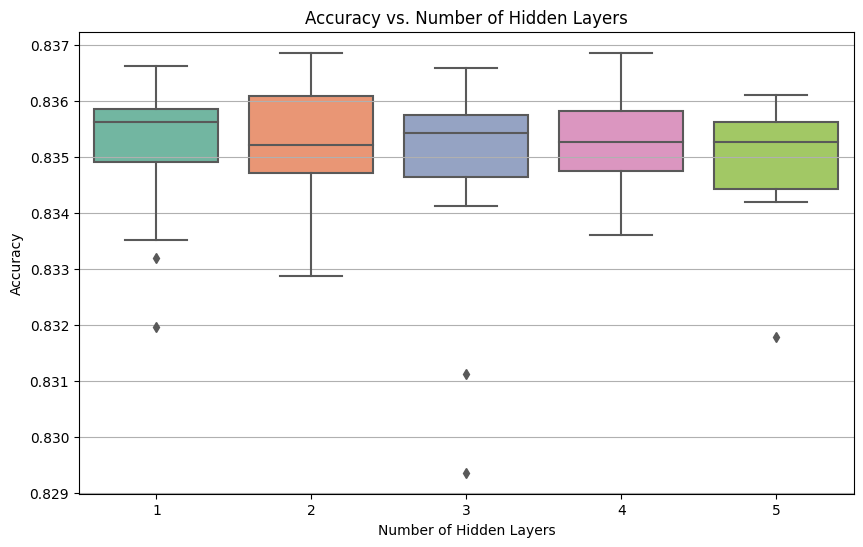

In [8]:


n_layers = [trial.params['n_layers'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials]


data = pd.DataFrame({'n_layers': n_layers, 'accuracy': accuracies})
plt.figure(figsize=(10, 6))
sns.boxplot(x='n_layers', y='accuracy', data=data, palette='Set2')


plt.title('Accuracy vs. Number of Hidden Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.grid(axis='y') 
plt.show()

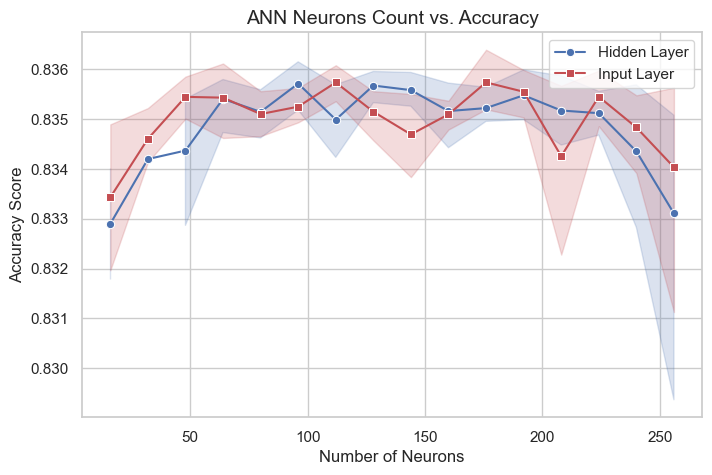

In [23]:
n_units_i = [trial.params['n_units_i'] for trial in study.trials]
n_units_h = [trial.params['n_units_h'] for trial in study.trials]
accuracies = [trial.value for trial in study.trials if trial.value is not None]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
sns.lineplot(x=n_units_h, y=accuracies, marker='o', color='b', label='Hidden Layer')
sns.lineplot(x=n_units_i, y=accuracies, marker='s', color='r', label='Input Layer')
plt.title('ANN Neurons Count vs. Accuracy', fontsize=14)
plt.xlabel('Number of Neurons', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.show()

In [10]:
def build_best_model(study, input_dim):
    model = Sequential()
    X, _ = load_data()
    model = Sequential()
    n_layers = study.best_params['n_layers']

    # Input Layer
    units = study.best_params['n_units_i']
    model.add(Dense(units, activation="relu", input_dim=input_dim))  # input_dim specified
    dropout_rate = study.best_params['dropout_rate']
    model.add(Dropout(dropout_rate))

    # Hidden Layers
    units_h = study.best_params['n_units_h']
    for i in range(n_layers):
        model.add(Dense(units_h, activation="relu"))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=study.best_params['lr']),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [11]:
X, y = load_data()
scaler = StandardScaler()
X = scaler.fit_transform(X)
    
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = build_best_model(study, X_train.shape[1])
    model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)


print(accuracy_score(y_test, y_pred))
joblib.dump(model, 'ann_model.joblib')

306/306 [==============================] - 0s 556us/step
0.8346642096642096
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\dropout_2
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2025-01-12 12:13:45         3183
metadata.json                         

['ann_model.joblib']